In [1]:
import matplotlib.pyplot as mpl
import matplotlib.ticker as ticker
import os, json, haversine
from dateutil import parser

In [2]:
# cd into manual testing data directory
os.chdir("../../INDOT/manual-gps")

# import results as dict of dicts
results = {}
for mode in os.listdir():
    results[mode] = {}
    for trial in os.listdir(mode):
        results[mode][trial] = json.load(open(os.path.join(mode,trial)))


In [3]:
# Sanity check / show example
list(results["Bicycle"].values())[0][0:3]

[{'frame': 0,
  'cam_gps': {'lat': '40.4220789', 'lon': '-86.9105216'},
  'gps_time': '2024-02-27T19:25:19.015000Z'},
 {'frame': 1,
  'cam_gps': {'lat': '40.422084', 'lon': '-86.9104769'},
  'gps_time': '2024-02-27T19:25:21.270000Z'},
 {'frame': 2,
  'cam_gps': {'lat': '40.4220915', 'lon': '-86.9104494'},
  'gps_time': '2024-02-27T19:25:22.260000Z'}]

In [4]:
confirmed = {
    "minutes" : {},
    "kilometers": {}
}

for mode in results:
    time = 0
    dist = 0
    for trial in results[mode]:
        start = parser.isoparse(results[mode][trial][0]["gps_time"])
        end = parser.isoparse(results[mode][trial][-1]["gps_time"])
        
        duration = end - start
        duration = duration.total_seconds()
        
        if start.year > 2022: # ignore if GPS not tracked at beginning
            time += duration
        elif duration < 60*60*10: # unless GPS was NEVER tracked
            time += duration

        trialdistance = 0
        for i in range(1,len(results[mode][trial])):
            p1 = results[mode][trial][i-1]["cam_gps"]
            p2 = results[mode][trial][i]["cam_gps"]
            dd = haversine.haversine(
                point1=(float(p1["lat"]), float(p1["lon"])),
                point2=(float(p2["lat"]), float(p2["lon"])),
                unit=haversine.Unit.METERS
            )
            trialdistance += dd
        if mode != "Car":
            if trialdistance/1000 > 50: pass # ignore bike/foot trips over 50km
            else: dist += trialdistance
        else:
            if trialdistance/1000 > 250: pass # ignore car trips over 250km
            else: dist += trialdistance
    
    confirmed["minutes"][mode] = time/60
    confirmed["kilometers"][mode] = dist/1000

confirmed

{'minutes': {'Automobile': 416.12910000000005,
  'Bicycle': 34.666638883333334,
  'Walk': 10.683925916666668},
 'kilometers': {'Automobile': 92.84290846949476,
  'Bicycle': 2.459298726506346,
  'Walk': 1.0551420146183272}}

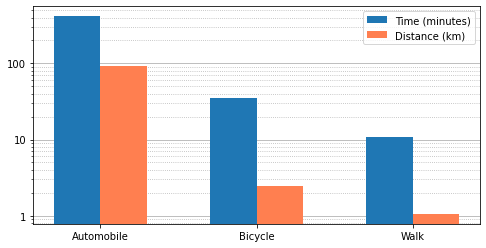

In [11]:
fig, axs = mpl.subplots(figsize=(8,4))
x = [i for i in range(len(results))]
timedata = list(confirmed["minutes"].values())
distdata = list(confirmed["kilometers"].values())

# Prepare axes
axs.set_yscale("log")
axs.yaxis.set_major_formatter(ticker.ScalarFormatter())
axs.grid(visible=True, which="major", axis="y")
axs.grid(visible=True, which="minor", axis="y", linestyle=":")
axs.set_axisbelow(True)

# Plot data
bar_width = 0.3
timebar = axs.bar([i-0.15 for i in x], timedata, width=bar_width, color="tab:blue")
distbar = axs.bar([i+0.15 for i in x], distdata, width=bar_width, color="coral")

# Add labels
timebar.set_label("Time (minutes)")
distbar.set_label("Distance (km)")
mpl.legend()
axs.set_xticks(ticks=x, labels=list(confirmed["minutes"].keys()),)

os.chdir("../../thesis/img")
mpl.savefig("manual_results.png", dpi=600)
mpl.show()